In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data/events_prepared.csv")
df = df.dropna()
df.head()

,Unnamed: 0,web-scraper-order,name,description,price,address,category,date_formatted,time_from,time_until,...,description_len,lat,lon,bfs_nummer,gemeinde,distance_bahnhof,kanton,absolute_young_pop,relative_young_pop,pop_dens
4,4,1701178312-1239,BELPHEGOR 30 Year Tour Special Guest: Arkona &...,belphegor marschiert durch europa winter mmxxi...,38.0,"Aarburg, CH",Konzert / Hard Rock & Heavy Metal,2023/12/01,19:00:00,23:50:00,...,734.0,47.324833,7.905110,4271,Aarburg,559.350472,AG,2691.0,30.8,1781.0
5,5,1701178314-1240,Leandro,leandro ao vivo com suas canções romanticas u...,53.0,"Industriestrasse 3, Niederlenz",Konzert / Weitere Musikrichtungen,2023/12/01,19:00:00,02:00:00,...,79.0,47.399548,8.163142,4204,Niederlenz,1077.491817,AG,1189.0,24.9,1415.4
10,10,1701178324-1245,Mataora Sound Journey,experience a vibrant sound journey with mataor...,35.0,"Zollikerstrasse 74, Zürich",Konzert / World & Ethno,2023/12/01,18:30:00,22:00:00,...,811.0,47.359894,8.557065,261,Zürich,1134.193055,ZH,150915.0,35.3,4580.5
15,15,1701178173-1172,BBR (CH),hard 'n' heavy covers! - bbr heizt mit den bes...,30.0,"Bahnhofstrasse 180b, Seewen",Konzert / Hard Rock & Heavy Metal,2023/12/01,21:00:00,22:30:00,...,886.0,47.029919,8.628654,1372,Schwyz,473.259997,SZ,4176.0,26.6,279.9
24,24,1701178196-1181,Ay Wing im Schtei,"die in berlin lebende, zuger künstlerin ay win...",35.0,"Kronengasse 1, Sempach",Konzert / Rhythm & Blues,2023/12/01,20:30:00,23:55:00,...,549.0,47.135468,8.192130,1102,Sempach,2178.022833,LU,858.0,20.8,460.8


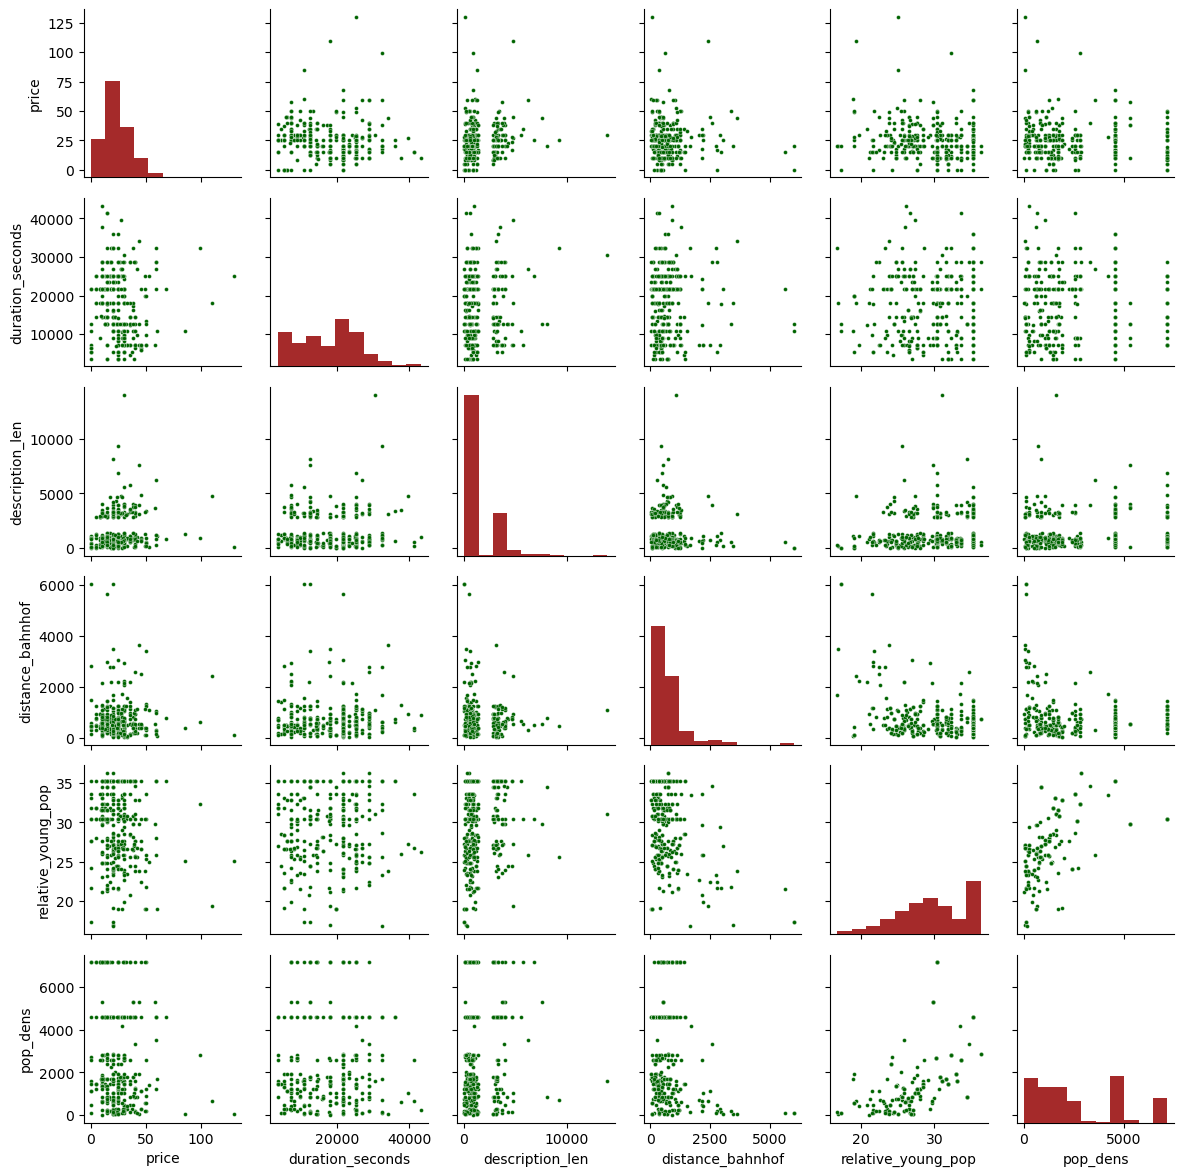

In [3]:
g2 = sns.PairGrid(df[['price', 'duration_seconds', 'description_len', 'distance_bahnhof', 'relative_young_pop', 'pop_dens']], 
                 height=2, 
                 aspect=1)
g2.map_upper(sns.scatterplot,color='darkgreen', s=8)
g2.map_lower(sns.scatterplot, color='darkgreen', s=8)
g2.map_diag(plt.hist, color='brown')
plt.show()

## Pearsons correlation

In [35]:
# Perform Persons correlation
res = stats.pearsonr(df['price'], df['duration_seconds'])

# Print result
print(f'Persons correlation coefficient (r): {res[0]:.4f}')
print(f'p-value: {res[1]:.4f}')

Persons correlation coefficient (r): -0.1201
p-value: 0.0189


The p-value is lower than 0.05 therefore the variables price and duration are significantly correlated. H0 can be rejected.

## T-Test

In [17]:
df_party = df.loc[df['is_concert'] == 0]
df_concert = df.loc[df['is_concert'] == 1]

result = stats.ttest_ind(df_party['price'], 
                         df_concert['price'])

print('Test-statistic:', result[0].round(5), 'p-value',  result[1].round(5))

Test-statistic: -4.69429 p-value 0.0


## ANOVA Test

In [18]:
fvalue, pvalue = stats.f_oneway(df_party['price'], df_concert['price'])

# Print results
print('F-value:', fvalue.round(3), 'p-value', pvalue.round(4))

F-value: 22.036 p-value 0.0


# Simple linear regression

## Create train and test samples

In [28]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df['distance_bahnhof'], 
                                                    df['price'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
683      592.997088
1344     106.210555
935     1088.015804
392      158.096898
980      344.465449
Name: distance_bahnhof, dtype: float64 

y_train:
683     26.0
1344    30.0
935     30.0
392     25.0
980     17.0
Name: price, dtype: float64


In [29]:
# Fit the regression model
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            25.35
Slope of regression line (beta):          -0.001
p-value:                                  0.5513
R-squared (coefficient of determination): 0.0012


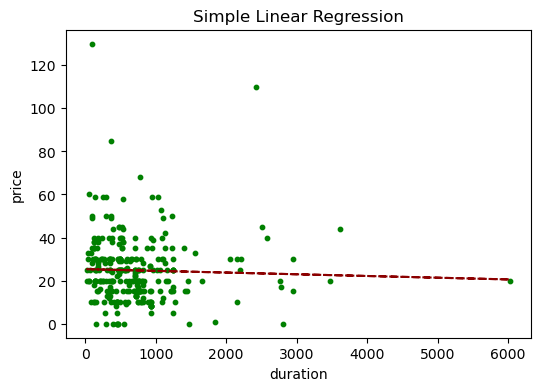

In [30]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('duration')
plt.ylabel('price')

plt.show()